# How to resume a simulation

This tutorial shows how to resume a simulation with the states coming from a previous simulation. It also speeds up the generation of results because after estimating parameters on some data, you can use the last day of the simulation results to run multiple counterfactual simulations.

In the following we use the same model as in the [how to simulate](how_to_simulate.ipynb) tutorial.

1. We will simulate data for some periods.
2. Inspect the simulation results.
3. Restart the simulation.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sid
from sid.config import INDEX_NAMES

## Simulate the data

<div class="alert alert-info">
    If you are familiar with the tutorial, skip this step and
    start immediately with the
    [continuation of the simulation](#Resume-the-simulation).
</div>

Let's create an artificial population of 10 000 people. 
Every individual will be characterized by its region and age group.

The age group will affect the progression of the disease.
Both region and age group will have an influence on who our individuals are going to meet.

In [2]:
available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=10_000)
regions = np.random.choice(["North", "South"], size=10_000)

initial_states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")
initial_states.head(5)

,age_group,region
0,50-59,North
1,50-59,South
2,80-100,North
3,30-39,South
4,20-29,South


### Specifying the Contact Models

Next, let's define how many contacts people have every day. 
We assume people have two types of contacts, close and distant contacts. They also have fewer close than distant contacts.

In [3]:
def meet_distant(states, params):
    possible_nr_contacts = np.arange(10)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params):
    possible_nr_contacts = np.arange(5)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "distant": {"model": meet_distant, "assort_by": assort_by, "is_recurrent": False},
    "close": {"model": meet_close, "assort_by": assort_by, "is_recurrent": False},
}

### Specifying the model parameters

sid allows to estimate one infection probability per contact type. 
In this example, close contacts are more infectious than distant contacts with 5% versus 3%. 

In [4]:
epidemiological_parameters = pd.read_csv("infection_probs.csv", index_col=INDEX_NAMES)
epidemiological_parameters

value  note  source
category       subcategory name                          
infection_prob close       close       0.05   NaN     NaN
               distant     distant     0.03   NaN     NaN
               household   household   0.20   NaN     NaN

Similarly, we specify for each contact model how assortatively
people meet across their respective `assort_by` keys. 

We assume that 90% of contacts are with people from the same region and 50% with contacts of the same age group as oneself for both "meet_close" and "meet_distant". 
The rest of the probability mass is split evenly between the other regions and age groups.

In [5]:
assort_probs = pd.read_csv("assort_by_params.csv", index_col=INDEX_NAMES)
assort_probs

value  note  source
category             subcategory name                          
assortative_matching close       age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN
                     distant     age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN

Lastly, we load some parameters that specify how Covid-19 progresses. This includes asymptomatic cases and covers that sever cases are more common among the elderly.

`cd_` stands for countdown. When a countdown is -1 the event never happens. So for example, 25% of infected people will never develop symptoms and the rest will develop symptoms 3 days after they start being infectious. 

In [6]:
disease_params = sid.get_epidemiological_parameters()
disease_params.head(6).round(2)

value
category           subcategory        name                     
health_system      icu_limit_relative icu_limit_relative  50.00
cd_immune_false    all                1000                 1.00
cd_infectious_true all                1                    0.39
                                      2                    0.35
                                      3                    0.22
                                      5                    0.04

In [7]:
params = pd.concat([disease_params, epidemiological_parameters, assort_probs])

### Contact Policies

We also allow the government to react to the rising number of infections by enforcing a
mild curfew which halves the contacts of all individuals if 10% of all individuals are
infectious.

You could also implement policies inside the contact models. This allows you more flexibility. For example, we could implement that sick individuals stay home, that vulnerable people react with stricter social distancing or implement the [locally adaptive lockdown policy in Germany](https://www.dw.com/en/merkel-cautiously-optimistic-as-she-announces-lockdown-rollback/a-53346427).

In [8]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1


contact_policies = {
    "policy_close_contacts": {
        "start": "2020-03-12",
        "policy": 0.5,
        "is_active": contact_policy_is_active,
        "affected_contact_model": "close",
    },
    "policy_distant_contacts": {
        "start": "2020-03-12",
        "policy": 0.5,
        "is_active": contact_policy_is_active,
        "affected_contact_model": "distant",
    },
}

Finally, there must be some initial infections in our population. This is specified via the initial conditions which are thouroughly explained in the [how-to guide](../how_to_guides/how_to_use_initial_conditions.ipynb). For now, we assume that there are 100 infected individuals and 50 with pre-existing immunity.

In [9]:
initial_conditions = {"initial_infections": 100, "initial_immunity": 50}

### Run the simulation

We are going to simulate this population for 200 periods.

In [10]:
simulate = sid.get_simulate_func(
    initial_states=initial_states,
    contact_models=contact_models,
    params=params,
    contact_policies=contact_policies,
    initial_conditions=initial_conditions,
    duration={"start": "2020-02-27", "periods": 100},
    path=".sid-first",
    seed=0,
)
result_first = simulate(params=params)

Start the simulation...
2020-06-05: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.60it/s]


## Resume the simulation

To indicate that you want to resume a simulation at the last date of the previous simulation, two conditions have to be met.

1. The ``states`` need to have a ``"date"`` or a ``"period"`` column.
2. You must not pass ``initial_conditions`` to `get_simulate_func`.

After that, it is also ensured that the states include all necessary information to resume the simulation, for example, data on health statuses and countdowns. You also have to adjust the duration of the simulation which must start one day after the previous simulation ended.

In [11]:
duration = {"start": "2020-06-06", "periods": 100}

In [12]:
last_states = result_first["last_states"].compute()

In [13]:
simulate = sid.get_simulate_func(
    initial_states=last_states,
    contact_models=contact_models,
    params=params,
    contact_policies=contact_policies,
    duration=duration,
    path=".sid-second",
    seed=0,
)

In [14]:
result_second = simulate(params)

Resume the simulation...
2020-09-13: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.14it/s]


In [15]:
time_series = pd.concat(
    [
        result_first["time_series"].compute().assign(period="Initial simulation"),
        result_second["time_series"].compute().assign(period="Resumed simulation"),
    ]
)

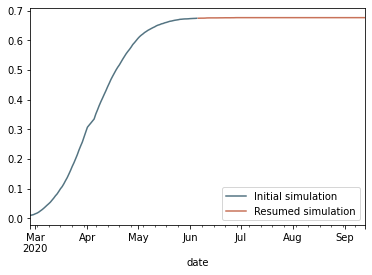

In [16]:
for (period, df), color in zip(
    time_series.groupby("period"),
    sid.get_colors("categorical", 2),
):
    df.resample("D", on="date")["ever_infected"].mean().plot(
        color=color, label=period, legend=True
    )

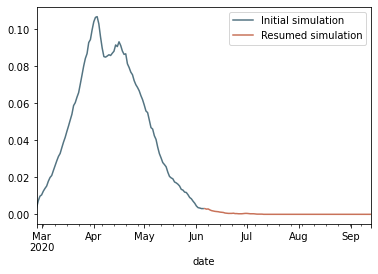

In [17]:
for (period, df), color in zip(
    time_series.groupby("period"),
    sid.get_colors("categorical", 2),
):
    df.resample("D", on="date")["infectious"].mean().plot(
        color=color, label=period, legend=True
    )

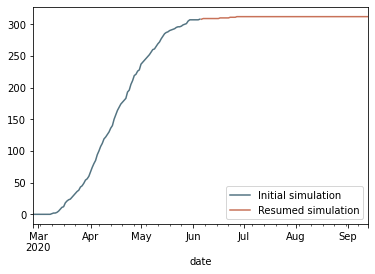

In [18]:
for (period, df), color in zip(
    time_series.groupby("period"),
    sid.get_colors("categorical", 2),
):
    df.resample("D", on="date")["dead"].sum().plot(
        color=color, label=period, legend=True
    )

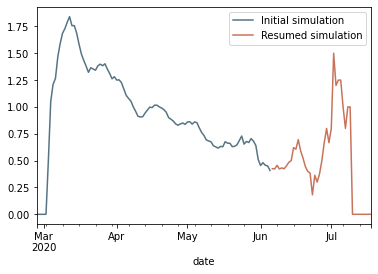

In [19]:
for (period, df), color in zip(
    time_series.groupby("period"),
    sid.get_colors("categorical", 2),
):
    infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
    df.loc[infectious_last_seven_days].resample("D", on="date")[
        "n_has_infected"
    ].mean().plot(color=color, label=period, legend=True)